# Student: Aleksander Alan Prymek
# ID: 22263179

In [28]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

## EDA

In [29]:
df = pd.read_csv("./insurance.csv")
categorical_columns = ['gender', 'smoker', 'region']
numerical_columns = ['age', 'bmi', 'children', 'insurance_cost']
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [30]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [31]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [32]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

In [33]:
for col in categorical_columns:
    print(f'-------{col}-------')
    print(df[col].value_counts())

-------gender-------
male      676
female    662
Name: gender, dtype: int64
-------smoker-------
no     1064
yes     274
Name: smoker, dtype: int64
-------region-------
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


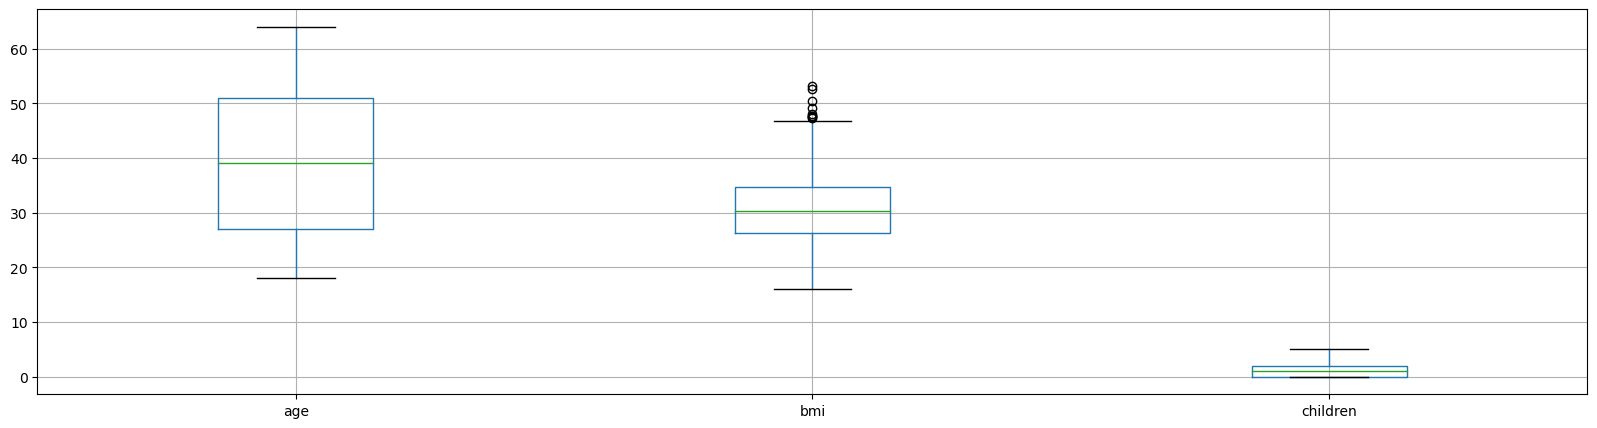

In [34]:
df.loc[:, ['age', 'bmi', 'children']].boxplot(figsize=(20,5))
plt.show()

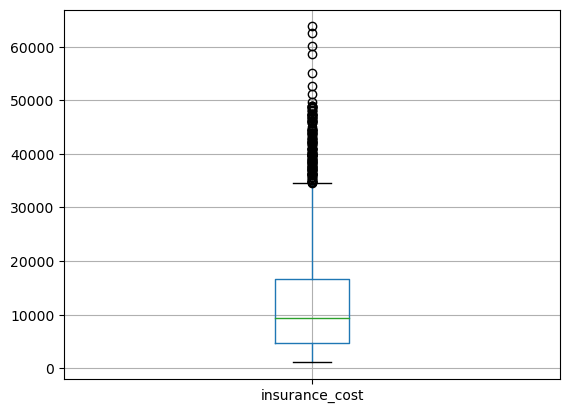

In [35]:
df.boxplot(column=['insurance_cost'])
plt.show()

Both `bmi` and `insurance_cost` have rather significant outliers.

## Data Preparation

First, we will convert the categorical columns. For `gender` and `smoker` we can simply map the values to $\{0, 1\}$. For `region` we will use one-hot encoding.

In [36]:
df['gender'] = df['gender'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

In [37]:
df = pd.get_dummies(df, columns=['region'], drop_first=True)

In [38]:
df.head()

age  gender     bmi  children  smoker  insurance_cost  region_northwest  \
0   18       0  33.770         1       0      1725.55230                 0   
1   18       0  34.100         0       0      1137.01100                 0   
2   18       1  26.315         0       0      2198.18985                 0   
3   18       1  38.665         2       0      3393.35635                 0   
4   18       1  35.625         0       0      2211.13075                 0   

   region_southeast  region_southwest  
0                 1                 0  
1                 1                 0  
2                 0                 0  
3                 0                 0  
4                 0                 0

We will rescale `bmi` and `insurance_cost` using log transformation and `RobustScaler`, while other columns with just `StandardScaler`.

In [39]:
names_outliers = ['bmi']
names_no_outliers = ['age', 'children']
names_all = df.columns.to_list()
names_all.remove('insurance_cost')
names_categorical = list(set(names_all) - set(names_outliers) - set(names_no_outliers))


class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [40]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ('outlier_columns', make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ('no_outlier_columns', make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        )),
        ('categorical_columns', make_pipeline(
            ColumnSelector(columns=names_categorical)
        ))
    ])
)

In [41]:
y = df['insurance_cost'].values
X = df.drop('insurance_cost', axis=1).values

# target has to be scaled separately 
y = RobustScaler().fit_transform(np.log(y).reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

### Random Forest

In [42]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('regression', RandomForestRegressor(n_estimators=10))
])

In [43]:
N_FEATURES_OPTIONS = [2, 4, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(RandomForestRegressor())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.805:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestRegressor(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regression__max_depth': 4}


### Linear Regression

In [44]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('regression', LinearRegression())
])

In [45]:
N_FEATURES_OPTIONS = [2, 4, 6, 8]
# NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        # 'regression__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        # 'regression__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.747:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=8), 'reduce_dim__n_components': 8}


### Compare Regression Models on Test Set

In [46]:
def evaluate_model(X_test, y_test, model):
    N = 10
    _predicted_values, _mse, _mae, _r2 = 0, 0, 0, 0
    for _ in range(N):
        _predicted_values += model.predict(X_test) / N
        _mse += mean_squared_error(y_test, _predicted_values) / N
        _mae += mean_absolute_error(y_test, _predicted_values) / N
        _r2 += r2_score(y_test, _predicted_values) / N
    return _mse, _mae, _r2

In [47]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

In [48]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### Train a Final Model

In [49]:
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(
    preprocess_pipeline,
    RF_best_params.get('reduce_dim'),
    RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regression__'))
)

final_model = pipe.fit(X, y)

In [50]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

### Third Regression Algorithm 

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

In [52]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('regression', GradientBoostingRegressor())
])

In [53]:
N_FEATURES_OPTIONS = [2, 6, 8]
LOSS_OPTIONS = ['squared_error', 'absolute_error', 'huber', 'quantile']
LR_OPTIONS = [0.01, 0.1]
N_ESTIMATORS_OPTIONS = [80, 90, 100]
CRITERION_OPTIONS = ['friedman_mse', 'squared_error']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(GradientBoostingRegressor())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__loss': LOSS_OPTIONS,
        'regression__learning_rate': LR_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS,
        'regression__criterion': CRITERION_OPTIONS,
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GB_best_params = search.best_params_
GB_best_model = search.best_estimator_

Best CV score = 0.811:
Best parameters:  {'reduce_dim': RFE(estimator=GradientBoostingRegressor(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'regression__criterion': 'friedman_mse', 'regression__learning_rate': 0.1, 'regression__loss': 'huber', 'regression__n_estimators': 80}


In [54]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
GB_mse, GB_mae, GB_r2 = evaluate_model(X_test, y_test, GB_best_model)

df_mse = pd.DataFrame({'GB': GB_mse,'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'GB': GB_mae,'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'GB': GB_r2,'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

The performance of the `GradientBoostingRegressor` is better than that of `RandomForestRegressor` or `LinearRegression`. `RandomForestRegressor` is roughly half-way between `GradientBoostingRegressor` and `LinearRegression`. `GradientBoostingRegressor` has the lowest MSE and MAE suggesting that it gets the lowest error in its predictions. It also has the highest R2. 

From wikipedia: R2 "is the proportion of the variation in the dependent variable that is predictable from the independent variable(s)". Thus, `GradientBoostingRegressor` with the highest R2 score has the greatest prediction power when it comes to the variation of the dataset.

## Dimensionality-reduction Methods

In [55]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import FastICA
from sklearn.decomposition import FactorAnalysis

In [56]:
# random forest 
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('regression', RandomForestRegressor(n_estimators=10))
])

N_COMPONENTS_OPTIONS_ICA = [2, 3, 4, 5]
N_COMPONENTS_OPTIONS_FA = [2, 4, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS_ICA,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS_FA,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.627:
Best parameters:  {'reduce_dim': FastICA(n_components=5), 'reduce_dim__n_components': 5, 'regression__max_depth': 8}


c:\Users\aleks\miniconda3\envs\tf\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [57]:
# linear regression 
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('regression', LinearRegression())
])

N_COMPONENTS_OPTIONS_ICA = [2, 3, 4, 5]
N_COMPONENTS_OPTIONS_FA = [2, 4, 6, 8]
# NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS_ICA,
        # 'regression__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS_FA,
        # 'regression__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.461:
Best parameters:  {'reduce_dim': FactorAnalysis(n_components=6), 'reduce_dim__n_components': 6}


In [58]:
# gradient boost
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('regression', GradientBoostingRegressor())
])

N_COMPONENTS_OPTIONS_ICA = [2, 3, 4, 5]
N_COMPONENTS_OPTIONS_FA = [2, 4, 6, 8]
LOSS_OPTIONS = ['squared_error', 'absolute_error', 'huber', 'quantile']
LR_OPTIONS = [0.01, 0.1]
N_ESTIMATORS_OPTIONS = [80, 90, 100]
CRITERION_OPTIONS = ['friedman_mse', 'squared_error']

param_grid = [
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS_ICA,
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS_FA,
        'regression__loss': LOSS_OPTIONS,
        'regression__learning_rate': LR_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS,
        'regression__criterion': CRITERION_OPTIONS,
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GB_best_params = search.best_params_
GB_best_model = search.best_estimator_

c:\Users\aleks\miniconda3\envs\tf\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Best CV score = 0.708:
Best parameters:  {'reduce_dim': FastICA(n_components=5), 'reduce_dim__n_components': 5}


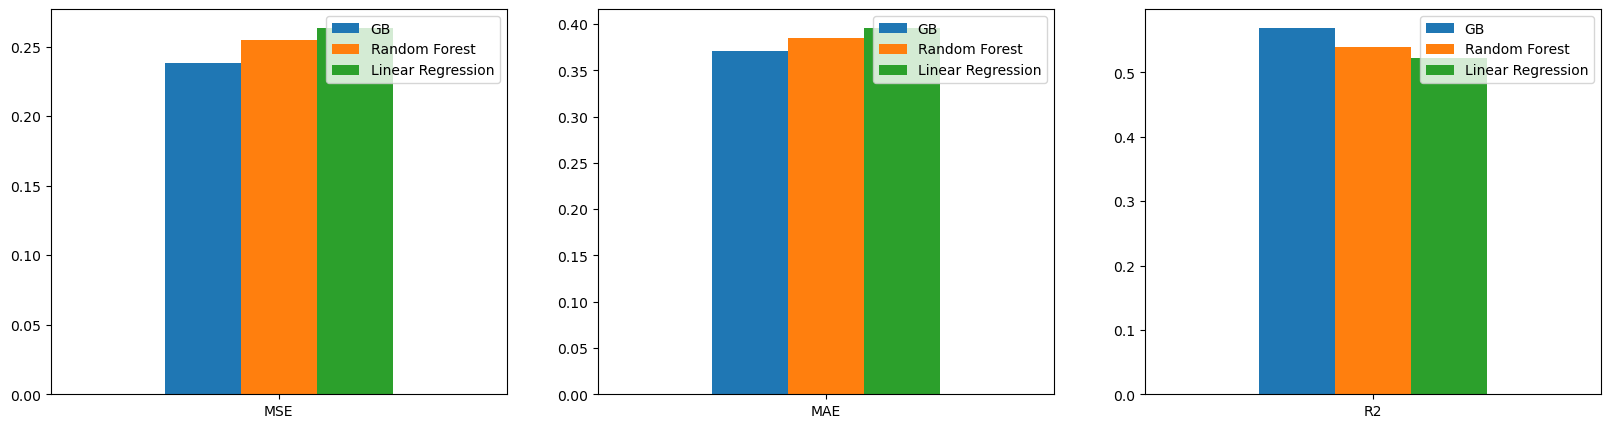

In [59]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
GB_mse, GB_mae, GB_r2 = evaluate_model(X_test, y_test, GB_best_model)

df_mse = pd.DataFrame({'GB': GB_mse,'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'GB': GB_mae,'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'GB': GB_r2,'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

- How do Random Forest and Linear Regression compare on the insurance dataset?

Overall, RF was superior to LR. RF performed best with RFE whereas LR with PCA. Neither FastICA nor Factor Analysis came close in performance to the other two dimensionality-reduction methods.

- What other dimensionality reduction methods have you tried (or intend to try) and what are the results?

FastICA and Factor Analysis was tried. Both performed worse than RFE or PCA with all three regression models. FastICA attempts at decomposing the signal into maximally independent additive components. Factor Analysis is a similar model to FastICA, however it assumes Gaussian priors on the latent variables.

- What other regression algorithm have you tried (or intend to try) and how does it compare to Random Forest and Linear Regression?

Gradient Boosting was tried. It performed better than either RF or LR.